In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from statsmodels.tsa.holtwinters import ExponentialSmoothing

%matplotlib inline

## Предобработка данных

In [2]:
low_freq_data_path = './data/low_freq.csv'
high_freq_data_path = './data/high_freq.csv'

low_forecast_period = 30
high_forecast_period = 40

def processing(df):
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(by='date')
    df['date'] = df['date'] - df['date'].min()
    df['date'] = df['date'].dt.days
    return df

l_df = processing(pd.read_csv(low_freq_data_path))
h_df = processing(pd.read_csv(high_freq_data_path))

## Низкочастотная номенклатура

Amount of sales: 15
Average smoothed value: 0.864


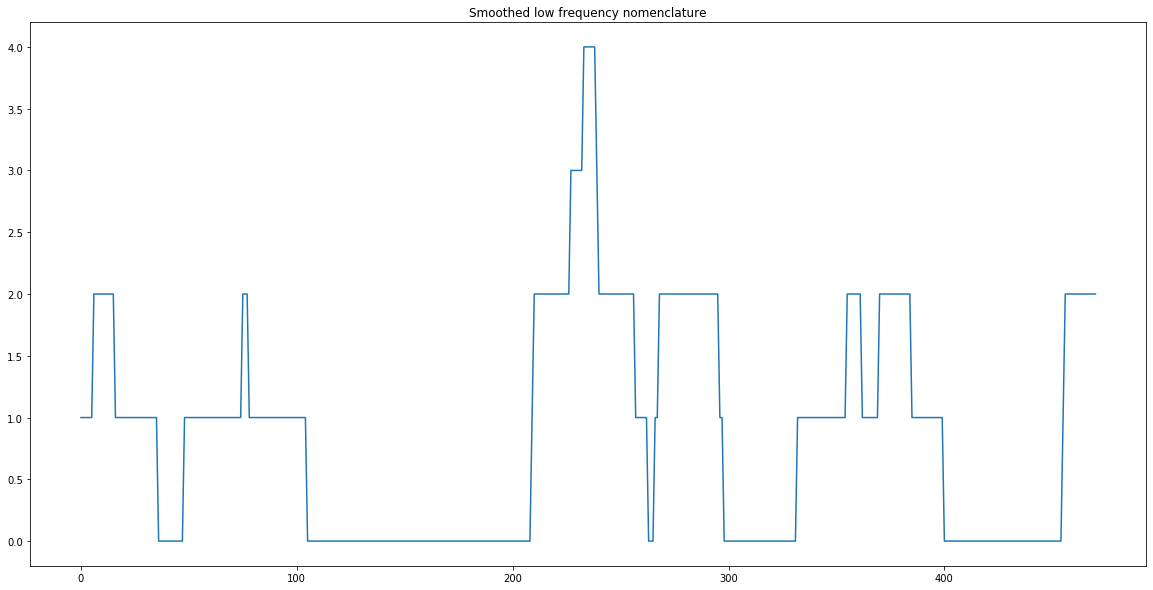

In [3]:
l_seq = np.zeros(max(l_df['date'].values) + 1)
for k, v in l_df.values:
    l_seq[k] = v
l_seq = np.convolve(l_seq, np.ones(low_forecast_period), 'same')

print(f'Amount of sales: {len(l_df)}')
print(f'Average smoothed value: {np.mean(l_seq):.3f}')

plt.figure(figsize=(20, 10))
plt.plot(np.arange(len(l_seq)), l_seq)
plt.title("Smoothed low frequency nomenclature")
plt.show()

## Выводы
Низкочастотная номенклатура имеет слишком мало записей для адекватного построения модели прогнозирования.

Из построенного графика видно, что за период предсказания продажа товара редко превышает 2 единицы, а среднее значение меньше 1.
С учетом того, что перезакуп продукции менее выгоден, рекомендуемая схема закупки товара: закупать не более 1 единицы товара в 30 дней.
Возможно, стоит рассмотреть закупку этого товара по предварительной заявке.

## Высокочастотная номенклатура

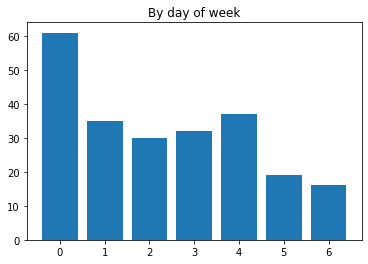

In [4]:
# Day of week distribution
day_of_week_hist = np.zeros(7)
for k, v in h_df.values:
    day_of_week_hist[k % 7] += v
plt.bar(range(len(day_of_week_hist)), day_of_week_hist)
plt.title('By day of week')
plt.show()

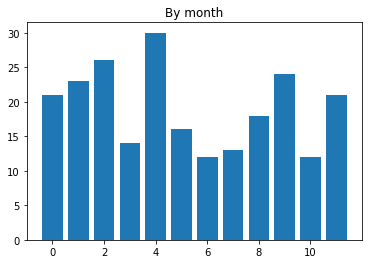

In [5]:
# By month sales
month_hist = np.zeros(12)
for k, v in h_df.values:
    month_hist[int(k / 30) % 12] += v
plt.bar(range(len(month_hist)), month_hist)
plt.title('By month')
plt.show()

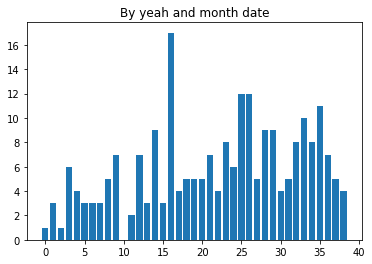

In [6]:
# By yeah and month sales
month_hist = np.zeros(int(max(h_df['date'].values) / 30 + 1))
for k, v in h_df.values:
    month_hist[int(k / 30)] += v
plt.bar(range(len(month_hist)), month_hist)
plt.title('By yeah and month date')
plt.show()

best validation loss: 1.445613896217446
best smoothing_level: 0.20
best smoothing_slope: 0.20
buying score mean: 0.9790863002037581
buying score std: 0.31812852275557574


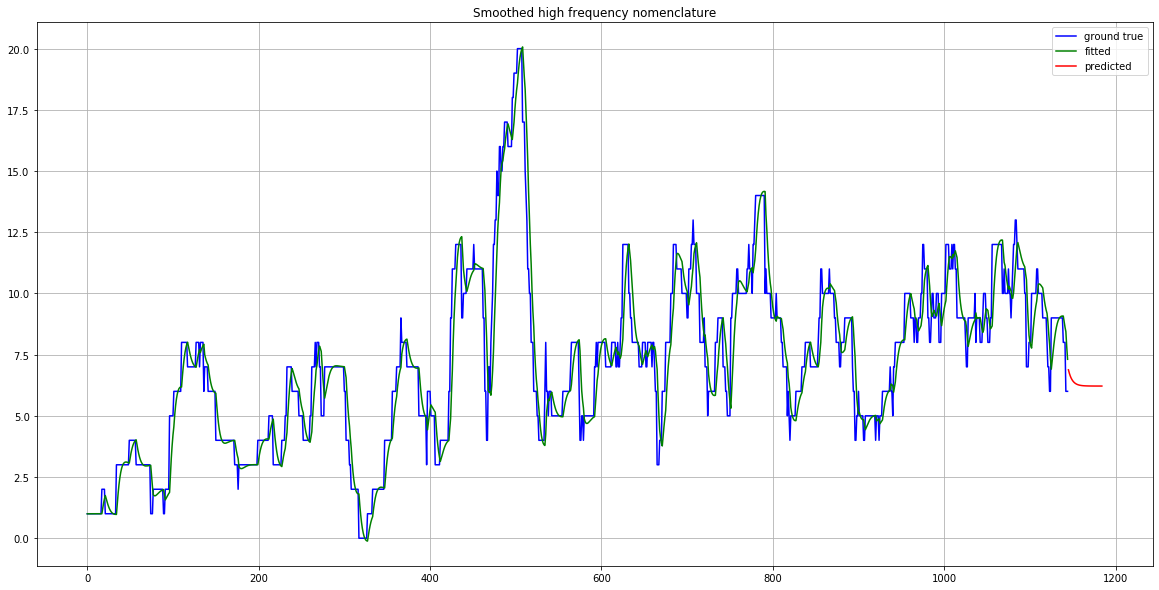

In [7]:
# Time series prediction based on exponential smoothing
h_seq = np.zeros(max(h_df['date'].values) + 1)
for k, v in h_df.values:
    h_seq[k] = v
h_seq = np.convolve(h_seq, np.ones(high_forecast_period), 'same')

best_smoothing_level = None
best_smoothing_slope = None
best_loss = np.inf
buying_score_mean = None
buying_score_std = None
for smoothing_level in np.arange(0, 2, 0.1):
    for smoothing_slope in np.arange(0, 1, 0.1):
        losses = []
        buying_score_history = []
        for split_point in range(int(0.8 * max(h_df['date'].values)),
                                 max(h_df['date'].values) - high_forecast_period,
                                 high_forecast_period):
            h_seq_train, h_seq_val = h_seq[:-split_point], h_seq[-split_point:]
            model = ExponentialSmoothing(h_seq_train, trend='add', damped=True)
            h_model = model.fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_slope)
            h_pred = h_model.forecast(high_forecast_period)
            loss = np.abs(h_seq_val[:high_forecast_period] - h_pred).mean()
            cur_buying_score = (np.sum(h_pred) + 1) / (np.sum(h_seq_val[:high_forecast_period]) + 1)
            buying_score_history.append(cur_buying_score)
            losses.append(loss)
        common_loss = np.mean(losses)
        if common_loss < best_loss:
            best_loss = common_loss
            best_smoothing_level = smoothing_level
            best_smoothing_slope = smoothing_slope
            buying_score_mean = np.mean(buying_score_history)
            buying_score_std = np.std(buying_score_history)

print(f'best validation loss: {best_loss}')
print(f'best smoothing_level: {best_smoothing_level:.2f}')
print(f'best smoothing_slope: {best_smoothing_slope:.2f}')
print(f'buying score mean: {buying_score_mean}')
print(f'buying score std: {buying_score_std}')

model = ExponentialSmoothing(h_seq, trend='add', damped=True)
h_model = model.fit(smoothing_level=best_smoothing_level,
                    smoothing_slope=best_smoothing_slope)
h_pred = h_model.forecast(high_forecast_period)

plt.figure(figsize=(20, 10))
plt.plot(np.arange(len(h_seq)), h_seq, color='blue', label='ground true')
plt.plot(np.arange(len(h_seq)), h_model.fittedvalues, color='green', label='fitted')
plt.plot(np.arange(len(h_seq), len(h_seq) + high_forecast_period), h_pred, color='red', label='predicted')
plt.title("Smoothed high frequency nomenclature")
plt.legend()
plt.grid()
plt.show()

## Выводы
Наблюдается определенная зависимость продаж от дня недели. Учитывать эту информацию не выходит, поскольку наблюдаемый период кратно больше.

Корреляция с месяцем года не столь явна. Возможно, что для выявления данной зависимости недостаточно данных (имеющиеся могут быть зашумлены выбросами).

Поскольку дополнительной информации по продажам номенклатуры не имеется, для построения модели предсказания выбрал метод экспоненциального сглаживания временных рядов.

В условии задания сказано, что перезакуп менее желателен, чем недозакуп. Но опереться на данный факт при построении подбора гиперпараметров не получается, потому что не очевидна данная зависимость.